# Plot cross-section profile of slip

2025.3.24 Kurama Okubo

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
import matplotlib as mpl

%matplotlib inline
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time

from importParaviewColormap import importParaviewColormap
import seaborn as sns
from matplotlib.collections import LineCollection

%load_ext autoreload
%autoreload 2


plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75

In [2]:
figdir = "../figure/aux03_cross-section"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [3]:
E = 96e9
nu = 0.246 # metagabbro
mu = E/(2*(1+nu))

a_patch = 4.0e-3
a_nuc = 2.5e-3 # nucleation radius 

nb_x_elements = 1024 #128 #1024
nb_z_elements = 1024 #128 #1024


Ifmasteroutput=True # add file key to the master output
if Ifmasteroutput:
    filekey = "_master"
else:
    filekey = ""

In [4]:
# case study parameter casename

a_patch = 4.0e-3
a_nuc = 2.5e-3
a_margin = 4.08e-3

rupturetype = "pulse"
pdcscaling = 0.60 #0.65
bgbeta= 0.35 #0.4

sig_n = 6e6

IfBinaryOutput = True

casestr_pulse = f"a={a_patch*1e3:.2f}_ruptype={"pulse"}_pdcscaling={pdcscaling:.3f}_sn={sig_n/1e6:.1f}MPa_hatfr=0.3_bgbeta={bgbeta:.2f}"
casestr_crack = f"a={a_patch*1e3:.2f}_ruptype={"crack"}_pdcscaling={pdcscaling:.3f}_sn={sig_n/1e6:.1f}MPa_hatfr=0.3_bgbeta={bgbeta:.2f}"

finame=f"../../preprocess_modelsetup/data/gouge_dynamicrupture_modelparam_{casestr_pulse}{filekey}.csv"

# Read model parameters
df_modelparam = pd.read_csv(finame, index_col=0)


datadir_root = "/Volumes/Okuboetal2025_masterHDD/RuptureSimulation/main_casestudy/build_hpcv62_mastercase_v3/simulations_main_casestudy_hpc_master"


In [5]:
df_modelparam.head()

,M0_mean,Tw_mean,Mw_mean,hat_sn_patch,hat_sn_background,delsig_withmargin_try,slip_try,initialstress_fraction,delsigma_factor,fp_patch,...,GIIC_patch,GIIC_background,Sratio_nuc,Sratio_patch,Ainit_nuc,Ainit_patch,Anuc_nuc,Anuc_patch,rnuc_nuc,rnuc_patch
gougeevent_id,,,,,,,,,,,,,,,,,,,,,
4,0.592607,0.000003,-6.221489,6000000.0,2000000.0,3817368.370,2.941529e-07,0.925,0.6,0.737013,...,0.063389,0.0,0,0.144801,3.82,3.827670,0.000002,0.000002,0.783304,0.784090
9,0.046991,0.000002,-6.955323,6000000.0,2000000.0,302700.368,2.332502e-08,0.925,0.6,0.357049,...,0.001808,0.0,0,0.884659,3.82,5.060161,0.000005,0.000007,1.311379,1.509311
18,0.755830,0.000003,-6.151051,6000000.0,2000000.0,4868794.570,3.751721e-07,0.925,0.6,0.850680,...,0.092430,0.0,0,0.131041,3.82,3.825794,0.000002,0.000002,0.719315,0.719860
19,0.055755,0.000002,-6.905809,6000000.0,2000000.0,359156.898,2.767536e-08,0.925,0.6,0.363152,...,0.002218,0.0,0,0.758343,3.82,4.624378,0.000005,0.000007,1.312650,1.444255
20,0.865466,0.000003,-6.111833,6000000.0,2000000.0,5575033.400,4.295923e-07,0.925,0.6,0.927031,...,0.114155,0.0,0,0.124712,3.82,3.825041,0.000001,0.000001,0.685213,0.685665


In [6]:
# Select gouge event id to plot the snapshots
expr_id = 87
gougeevent_id = 129 # 24, 50, 52, 72, 129

In [7]:
df_modelparam_selected = df_modelparam[df_modelparam.index == gougeevent_id]

# if ifParamStudy:
simulation_name_pulse = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr_pulse}_{df_modelparam_selected.delsigma_factor.values[0]:.4f}"
simulation_name_crack = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr_crack}_{df_modelparam_selected.delsigma_factor.values[0]:.4f}"

print(f"Process {gougeevent_id}: {simulation_name_pulse} and {simulation_name_crack}")


Process 129: fb03-087__0129_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.4100 and fb03-087__0129_a=4.00_ruptype=crack_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.4100


# Read profile

We used `offset` and `count` to partially read binary file to increase the i/o speed.

In [8]:
# time and coordinates are same for pulse and crack cases

df_time = pd.read_csv(os.path.join(datadir_root,simulation_name_pulse+".time"), header=None, sep=' ', index_col=0)
df_coord = pd.read_csv(os.path.join(datadir_root,simulation_name_pulse+".coords"), header=None, sep=' ', index_col=None)
NT=len(df_time)


In [9]:
# location of the center of nucleation zone
nuc_x = -(a_patch - a_nuc)
nuc_z = 0

xcoord = df_coord.loc[:,0].values
zcoord = df_coord.loc[:,2].values

x_length = xcoord.max()
z_length = zcoord.max()

# ref also: https://stackoverflow.com/a/35176314
dgrid = (zcoord[1] - zcoord[0])
print(f"Grid size: {dgrid*1e3}[mm]") 

X = xcoord.reshape(nb_x_elements,nb_z_elements).T- dgrid/2 - x_length/2
Z = zcoord.reshape(nb_x_elements,nb_z_elements).T- dgrid/2 - z_length/2



Grid size: 0.0390625[mm]


In [10]:
read_comp = 0 #0: Mode II direction, 1: normal (Mode I), 2:Mode III direction 

data_disp_all = dict()
tplot_list = [0.6e-6, 1.0e-6, 1.6e-6, 6.0e-6] # plot time list

for tplot in tplot_list:
    
    tind = np.where(df_time.values >= 0.99*tplot)[0][0] # search the time index of tplot
    
    Nchank = nb_x_elements * nb_z_elements
    Noffset = Nchank * tind * np.dtype(np.float32).itemsize # skip untile the plot timing
    
    # read displacement
    read_parameter = f"top_disp_{read_comp}" # select the parameter to read
    if IfBinaryOutput:
        disp_pulse = np.fromfile(os.path.join(datadir_root,simulation_name_pulse+f"-DataFiles/{read_parameter}.out"), dtype="float32", offset=Noffset, count=Nchank)
        disp_crack = np.fromfile(os.path.join(datadir_root,simulation_name_crack+f"-DataFiles/{read_parameter}.out"), dtype="float32", offset=Noffset, count=Nchank)
        # df_data_disp = pd.DataFrame(data=D.reshape((NT, -1)))
    else:
        warnings.warn("only binary output available in this notebook.")
        # df_data_disp = pd.read_csv(os.path.join(datadir_root,simulation_name_pulse+f"-DataFiles/{read_parameter}.out"), header=None, sep=' ', engine="c")

    data_disp_all[f"{tplot*1e6}us_pulse"] = disp_pulse 
    data_disp_all[f"{tplot*1e6}us_crack"] = disp_crack 

# Plot cross-section

In [11]:
z_cross=0.0
trac_z_ind = np.where(Z[:, 0] >= z_cross)[0][0]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


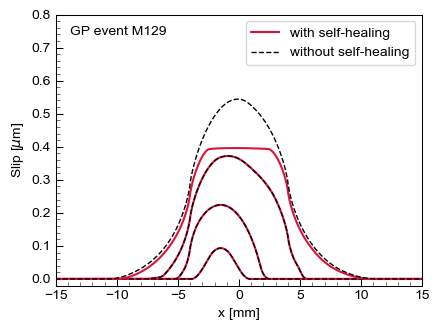

In [12]:
value_factor_double = 2.0 # double the value for slip and slip velocity


fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.4))

for i, tplot in enumerate(tplot_list):

    disp_crosssec_crack = data_disp_all[f"{tplot*1e6}us_crack"].reshape(nb_x_elements,nb_z_elements).T[trac_z_ind, :] 
    disp_crosssec_pulse = data_disp_all[f"{tplot*1e6}us_pulse"].reshape(nb_x_elements,nb_z_elements).T[trac_z_ind, :] 

    if i==0:
        label_c = "without self-healing"
        label_p = "with self-healing"
    else:
        label_c = ""
        label_p = ""
        
    ax.plot(X[0]*1e3, value_factor_double*disp_crosssec_pulse*1e6, c="crimson", lw=1.5, label=label_p)
    ax.plot(X[0]*1e3, value_factor_double*disp_crosssec_crack*1e6, c="k", lw=1, ls="--", label=label_c)
    
    ax.set_xlabel("x [mm]")
    ax.set_ylabel(r"Slip [$\mu$m]")
    ax.legend(loc=1)
    
    ax.set_xlim([-15, 15])
    ax.set_ylim([-0.02, 0.8])

ax.text(0.04, 0.925, f"GP event M{gougeevent_id}", transform=ax.transAxes)

plt.tight_layout()
plt.savefig(figdir + f"/cross-section_disp_{simulation_name_pulse}.png", dpi=80, bbox_inches="tight")
plt.savefig(figdir + f"/cross-section_disp_{simulation_name_pulse}.eps", bbox_inches="tight")

# Plot shear stress

In [13]:
read_comp = 0 #0: Mode II direction, 1: normal (Mode I), 2:Mode III direction 

data_coh_all = dict()
tplot_list = [0.3e-6, 6.0e-6] # plot time list

for tplot in tplot_list:
    
    tind = np.where(df_time.values >= 0.99*tplot)[0][0] # search the time index of tplot
    
    Nchank = nb_x_elements * nb_z_elements
    Noffset = Nchank * tind * np.dtype(np.float32).itemsize # skip untile the plot timing
    
    # read displacement
    read_parameter = f"cohesion_{read_comp}" # select the parameter to read
    if IfBinaryOutput:
        coh_pulse = np.fromfile(os.path.join(datadir_root,simulation_name_pulse+f"-DataFiles/{read_parameter}.out"), dtype="float32", offset=Noffset, count=Nchank)
        coh_crack = np.fromfile(os.path.join(datadir_root,simulation_name_crack+f"-DataFiles/{read_parameter}.out"), dtype="float32", offset=Noffset, count=Nchank)
        # df_data_disp = pd.DataFrame(data=D.reshape((NT, -1)))
    else:
        warnings.warn("only binary output available in this notebook.")
        # df_data_disp = pd.read_csv(os.path.join(datadir_root,simulation_name_pulse+f"-DataFiles/{read_parameter}.out"), header=None, sep=' ', engine="c")

    data_coh_all[f"{tplot*1e6}us_pulse"] = coh_pulse 
    data_coh_all[f"{tplot*1e6}us_crack"] = coh_crack 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


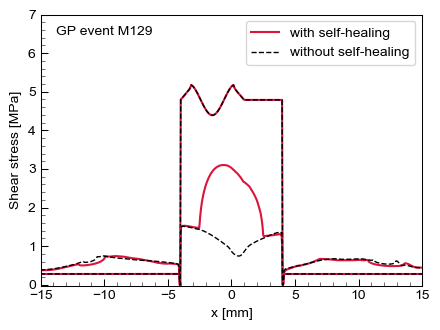

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.4))

for i, tplot in enumerate(tplot_list):

    coh_crosssec_crack = data_coh_all[f"{tplot*1e6}us_crack"].reshape(nb_x_elements,nb_z_elements).T[trac_z_ind, :] 
    coh_crosssec_pulse = data_coh_all[f"{tplot*1e6}us_pulse"].reshape(nb_x_elements,nb_z_elements).T[trac_z_ind, :] 

    if i==0:
        label_c = "without self-healing"
        label_p = "with self-healing"
    else:
        label_c = ""
        label_p = ""
        
    ax.plot(X[0]*1e3, coh_crosssec_pulse/1e6, c="crimson", lw=1.5, label=label_p)
    ax.plot(X[0]*1e3, coh_crosssec_crack/1e6, c="k", lw=1, ls="--", label=label_c)
    
    ax.set_xlabel("x [mm]")
    ax.set_ylabel(r"Shear stress [MPa]")
    ax.legend(loc=1)
    
    ax.set_xlim([-15, 15])
    ax.set_ylim([-0.02, 7])

ax.text(0.04, 0.925, f"GP event M{gougeevent_id}", transform=ax.transAxes)

plt.tight_layout()
plt.savefig(figdir + f"/cross-section_shearstress_{simulation_name_pulse}.png", dpi=80, bbox_inches="tight")
plt.savefig(figdir + f"/cross-section_shearstress_{simulation_name_pulse}.eps", bbox_inches="tight")